In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import json
from PIL import Image

In [9]:
labelled_json = json.load(open('./data/labeled_images.json', 'r'))
labelled_json[0]

{'image': 'frame_0655.jpg',
 'points': [{'x': 523, 'y': 348}, {'x': 548, 'y': 347}]}

In [10]:
def build_dataset(json_data):
    X, Y = [], []

    count = 0
    for item in json_data:
        count += 1
        img = Image.open('./data/raw_images/' + item['image'])
        img = img.resize((round(16/9 * 128), 128))
        img_tensor = torch.tensor(list(img.getdata()), dtype=torch.float32).view(3, 128, round(16/9 * 128))
        
        X.append(img_tensor)
        point_tensor = torch.tensor([item['points'][0]['x'], item['points'][0]['y'], item['points'][1]['x'], item['points'][1]['y']], dtype=torch.float32)
        Y.append(point_tensor)

        if count % 100 == 0:
            print(count)
    
    X = torch.stack(X)
    Y = torch.stack(Y)
    return X, Y


In [11]:
Xtr, Ytr = build_dataset(labelled_json[:int(len(labelled_json) * 0.8)])
print('loaded training data')
Xval, Yval = build_dataset(labelled_json[int(len(labelled_json) * 0.8):])
print('loaded validation data')

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
loaded training data
100
200
300
400
loaded validation data


In [5]:
X[0].shape

torch.Size([3, 128, 228])

In [6]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()

        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Define fully connected layers
        self.fc1 = nn.Linear(222208, 512)  # Adjust the input size based on your image dimensions
        self.relu3 = nn.ReLU()

        # Output layer
        self.fc2 = nn.Linear(512, 4)  # Output 4 logits

    def forward(self, x):
        # Input: (batch_size, channels, height, width)
        # Example: (batch_size, 3, 128, 228)

        # Convolutional layers
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu3(x)

        # Output layer
        x = self.fc2(x)

        return x

# m = SimpleConvNet()
# m = m.cuda()

In [103]:

class ResBlock(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, kernel_size=3, stride=1):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)
        self.relu2 = nn.ReLU()

        self.shortcut = nn.Sequential()
    
    def forward(self, x):
        shortcut = self.shortcut(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.bn1(x)

        x = self.conv2(x)
        x += shortcut
        x = self.relu2(x)
        # x = F.relu(x)
        x = self.bn2(x)


        return x


In [104]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.relu1 = nn.ReLU()
        
        self.res_blocks = nn.Sequential(
            ResBlock(in_channels=64, out_channels=64, kernel_size=3),
            ResBlock(in_channels=64, out_channels=64, kernel_size=3),
            ResBlock(in_channels=64, out_channels=64, kernel_size=3),
        )

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.ff = nn.Linear(in_features=64, out_features=4)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.pool1(x)

        x = self.res_blocks(x)

        x = self.gap(x)
        x = torch.flatten(x, 1)

        return self.ff(x)
    

In [105]:
m = ResNet().cuda()
m(Xtr[0].unsqueeze(0))


tensor([[-0.0819,  0.0547,  0.0261,  0.0722]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [95]:
m = SimpleConvNet()

NameError: name 'SimpleConvNet' is not defined

In [97]:
# get n parameters
n = sum(p.numel() for p in m.parameters())
print(n)

232196


In [106]:
m = m.cuda()
Xtr, Ytr = Xtr.cuda(), Ytr.cuda()
Xval, Yval = Xval.cuda(), Yval.cuda()

In [111]:
# Define the loss function and optimizer
criterion = nn.MSELoss().cuda()
optimizer = optim.Adam(m.parameters(), lr=3e-3)

In [112]:
lossi = []
vallossi = []

In [113]:
def estimate_loss(split, batch_size=32):
    losses = []
    X = Xtr if split == 'train' else Xval
    Y = Ytr if split == 'train' else Yval
    m.eval()
    for i in range(0, len(split), batch_size):
        X_batch = X[i:i + batch_size]
        Y_batch = Y[i:i + batch_size]

        # Forward pass
        with torch.no_grad():
            Y_pred = m(X_batch)

        # Compute loss
        loss = criterion(Y_pred, Y_batch)

        losses.append(loss.item())

    m.train()
    return sum(losses) / len(losses)

In [128]:
torch.autograd.set_detect_anomaly(True)

# training loop
best_val_loss = 1e9
for i in range(2000):
    # zero the parameter gradients
    optimizer.zero_grad()

    idx = torch.randint(0, Xtr.shape[0], (64,))
    X = Xtr[idx]
    Y = Ytr[idx]

    # print(X.device)
    

    # forward + backward + optimize
    outputs = m(X)
    loss = criterion(outputs, Y)
    loss.backward()
    optimizer.step()

    lossi.append(loss.item())

    # print statistics
    if i % 500 == 0:
        val_loss = estimate_loss('val')
        vallossi.append(val_loss)
        print(f"batch: {i}, train loss: {loss.item()}, val loss: {val_loss}")
        # if val_loss < best_val_loss:
        #     best_val_loss = val_loss
        #     print('saving best model')
        #     torch.save(m.state_dict(), './best_model.pt')

batch: 0, train loss: 425.471923828125, val loss: 1844.379638671875
batch: 500, train loss: 852.9207763671875, val loss: 847.8228759765625
batch: 1000, train loss: 882.4640502929688, val loss: 910.0767822265625
batch: 1500, train loss: 692.5909423828125, val loss: 708.272705078125


In [120]:
for g in optimizer.param_groups:
    g['lr'] = 3e-4

In [129]:
estimate_loss('val')

758.55517578125

In [131]:
estimate_loss('train')

555.6820678710938

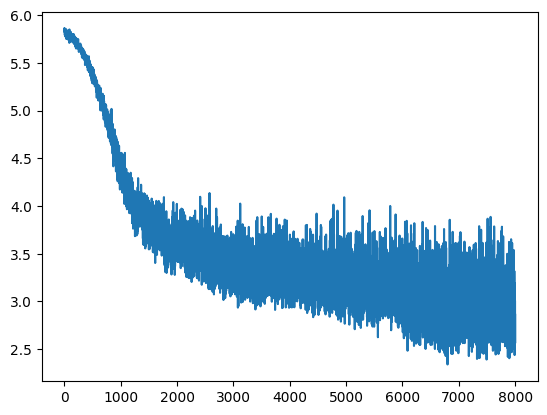

In [123]:
import matplotlib.pyplot as plt
plt.plot(torch.tensor(lossi).log10())

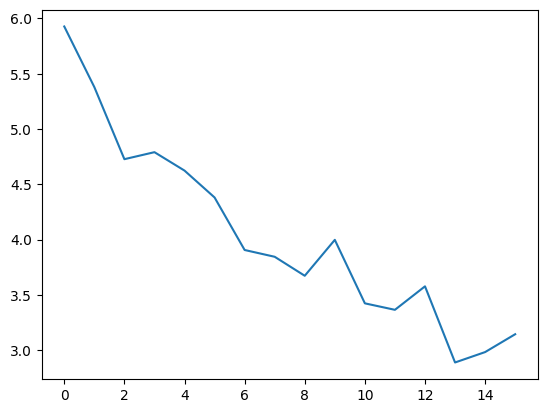

In [124]:
plt.plot(torch.tensor(vallossi).log10())

In [95]:
m(Xtr[0].unsqueeze(0))

x intial shape torch.Size([1, 3, 128, 228])
x after conv1 torch.Size([1, 64, 126, 226])
x after pool1 torch.Size([1, 64, 63, 113])
x after conv2 torch.Size([1, 128, 63, 113])
x after pool2 torch.Size([1, 128, 31, 56])
x after flattening torch.Size([1, 222208])
x after fc1 torch.Size([1, 512])
final x shape torch.Size([1, 4])


tensor([[ -3.5551,  -3.9806,   0.4860, -16.2665]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [12]:

img = Image.open('./test.jpg')
img = img.resize((round(16/9 * 128), 128))
# img = img.resize((1920, 1080), resample=Image.BILINEAR)
img.save('./test_resized.jpg')
img_tensor = torch.tensor(list(img.getdata()), dtype=torch.float32).view(3, 128, round(16/9 * 128))


In [13]:
m(img_tensor.unsqueeze(0).cuda())

tensor([[648.5787, 844.9042, 659.7710, 829.2066]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [130]:
torch.save(m.state_dict(), './best_model.pt')

In [66]:
torch.save(m.state_dict(), './model2.pt')

# losses
1: final val loss 2452